# Experiment description
## Hypothesis: 
Predictability localidad values are similar (presents low variance) over full dataset years

## Method: 
- Remove outliers
- Measure predictability for 7 days timewindows and levelCrime=3 over full dataset years 2014-2018
- Implement a metric to compare the difference among predictability values

## Parameters: 
- Time windows: 7
- Crime levels: 3
- Aggregation: localidades

## Built-in methods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import scipy
import math
from math import pi
import geopandas as gpd
import plotly.express as px
%matplotlib inline

In [2]:
workingPath= '/Users/anamaria/Desktop/dev/security_project/'

In [3]:
def set_initial_dataset_day(df_by_date,name_day):
    df_by_date = df_by_date.reset_index()
    df_by_date['day_of_week'] = df_by_date['date'].dt.day_name()
    monday_idx = df_by_date.index[df_by_date['day_of_week'] == name_day].tolist()[0]
    df_by_date = df_by_date[monday_idx:].set_index('date').drop(['day_of_week'],axis=1)
    return df_by_date

In [4]:
# Methods for time windows
def im2patches(im,n):
    patches = [];
    for i in range(len(im)-n):
        patch = im[i:(i+n-1)]        
        patch = patch - np.nanmean(patch);
        if(np.linalg.norm(patch)>0):
            patch = patch/np.linalg.norm(patch);
        if i==0:
            patches = patch;
        else:
            patches = np.vstack((patches,patch))
    return patches;

def writeEmbeding(timeSeries,lenWindow,samplePath, scenarioName):
    slicingWindows = im2patches(timeSeries,lenWindow);
    experimentPath = 'periodicity_experiments/predictability/slicing/'
    prevStation = str(samplePath);
    with open(workingPath+experimentPath+'slicingWindows'+"_"+str(prevStation)+"_"+str(scenarioName)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = slicingWindows.tolist();                        
        pickle.dump(lv, f, protocol=2)

    experimentPath = 'periodicity_experiments/predictability/timeSeries/'    
    with open(workingPath+experimentPath+'timeSeries'+"_"+str(prevStation)+"_"+str(scenarioName)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = timeSeries.tolist();                        
        pickle.dump(lv, f, protocol=2)



In [5]:
#Methods for predictability
def getBarcode(samplePath,lenWindow,scenarioName):
    experimentPath = 'periodicity_experiments/predictability/'
    barcode = [];

    with open(workingPath+experimentPath+'timeSeries/'+'timeSeries_'+samplePath+"_"+str(scenarioName)+'_'+str(lenWindow)+'_'+'.pickle', 'rb') as f:
            timeSeries = pickle.load(f);            
    return (barcode,timeSeries);

def computeBarcodeEntropy(barsLenB0):
    barlen = np.array(barsLenB0);
    barlen = barlen/barlen.sum();
    hbc = 0;
    for i in range(barlen.shape[0]):
        if barlen[i]!=0:
            hbc = hbc-(barlen[i])*np.log(barlen[i]);
    return hbc;


def computeGeneralPredictability(timeSeries,binsData,lenWindow):
    # Colwell, R. K. (1974). Predictability, constancy, and contingency of periodic phenomena. Ecology, 55(5), 1148-1153.
    # Normalize the caudal values
    nLevels = binsData.shape[0]-1;
    matStations = np.array(timeSeries).reshape((np.array(timeSeries).shape[0]//lenWindow,lenWindow))    

    grandMean = np.mean(np.mean(matStations));
    #matStations = matStations / grandMean;
    N = np.zeros((nLevels,lenWindow));
    for i in range(1,matStations.shape[1]): 
        # Computes histograms per columns
        hist, bin_edges = np.histogram(matStations[:,i],bins = binsData);
        N[:,i] = hist;
    X = np.sum(N, axis=0);
    Y = np.sum(N, axis=1);
    Z = np.sum(Y);
    hx = 0;
    hy = 0;
    hxy = 0;
    for j in range(X.shape[0]):
        if X[j]!=0:
            hx = hx-(X[j]/Z)*np.log(X[j]/Z);
            
    for i in range(Y.shape[0]):
        if Y[i]!=0:
            hy = hy-(Y[i]/Z)*np.log(Y[i]/Z);
            
    for i in range(Y.shape[0]):
        for j in range(X.shape[0]):
            if N[i,j]!=0:
                hxy = hxy-((N[i,j]/Z)*np.log(N[i,j]/Z));    
    
    # predictability
    p = 1 - (hxy - hx)/np.log(N.shape[0]);
    # constancy
    c = 1 - hy/np.log(N.shape[0]);
    # Returns constancy and contingency
    return (c,p-c,p);



In [6]:
def preprocess_df(df,min_date_period,max_date_period):
    df=df.drop(columns=['ANIO','LOCALIDAD'])
    #Remove outliers
    q_hi = df["total_eventos"].quantile(0.99)
    df = df[(df["total_eventos"] < q_hi)]

    #Make sure dataset include consecutive dates in period
    idx = pd.date_range(min_date_period, max_date_period)
    df = df.reindex(idx, fill_value=int(df["total_eventos"].mean()))
    df = df.reset_index().rename(columns={'index': 'date'}).set_index('date')
    
    #Make sure dataset starts on Monday for the experiment
    df = set_initial_dataset_day(df,'Monday')
    
    return df

In [7]:
def saveTimeSeries(df,min_date_period,max_date_period,localidad, lenWindow, expName):       
    df_values = pd.Series(df['total_eventos']).values
    lT=get_LT(df, lenWindow)
    df_values = df_values[0:lT]
    writeEmbeding(df_values,lenWindow,expName,localidad)

In [8]:
def get_LT(df_by_period,lenWindow):
    min_date = df_by_period.reset_index().date.min()
    max_date = df_by_period.reset_index().date.max()
    samples_num = (max_date.date()-min_date.date()).days
    lT = samples_num//lenWindow * lenWindow
    return lT

In [9]:
def predictability_experiment_localidades(df_by_date,min_date_period,max_date_period,lenWindow,localidadesList,Levels,expName,periodName):
    #workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictability/';

    flagF = True;
    for localidad in localidadesList:
        #write embeding
        df_by_localidad = df_by_date[df_by_date['LOCALIDAD'] == localidad]        
        df_by_localidad = preprocess_df(df_by_localidad,min_date_period,max_date_period)
        #print(df_by_localidad["total_eventos"])
        saveTimeSeries(df_by_localidad,min_date_period,max_date_period,localidad, lenWindow, expName)
        
        for nLevels in Levels:
            (barcode,timeSeries) = getBarcode(expName,lenWindow,localidad);
            binsLevels = np.linspace(np.min(timeSeries),np.max(timeSeries),nLevels);
            c,m,p = computeGeneralPredictability(timeSeries,binsLevels,lenWindow)

            if flagF==True:
                flagF = False
                predValues = np.array([expName,periodName,localidad,lenWindow,nLevels,p,m,c]);
            else:
                predValues = np.vstack((predValues, [expName,periodName,localidad,lenWindow,nLevels,p,m,c]))

    return predValues
        
    

In [10]:
def table_predictability_variance(df_agressiveBehavior,lenWindow,localidadesList,yAxisCategories,name_experiment,nLevel):
    join=df_agressiveBehavior.pivot('localidad','period','square_diff')
    var1_order = []
    var2_order = yAxisCategories
    if len(var2_order) > 0:
        join = join.reindex(var2_order, axis=1)
    if len(var1_order) > 0:
        join = join.reindex(var1_order)
    
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    fig.set_size_inches(6, 6)
    g=sns.heatmap(join.astype('float'),annot=True,fmt=".2",linewidths=0,cmap="Blues",cbar=False)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_ylabel("Locality")
    ax.set_xlabel("Period")
    file_path = 'periodicity_experiments/predictability/figures/'
    plt.savefig(workingPath+file_path+'table_'+str(name_experiment)+'_p_square_diff_time_'+str(lenWindow)+'_levels_'+str(nLevel),dpi=300,bbox_inches = "tight")
    plt.show()

In [11]:
def map_localidad(ax,df,col_localidad,col_vals,vmin=None,vmax=None):
  loc_geo=workingPath+"assets/localidades_polygon.json"
  loc_=gpd.read_file(loc_geo)
  loc_=loc_.merge(df,left_on='LocNombre',right_on=col_localidad)
  loc_.plot(cmap='viridis',edgecolor='white',column=col_vals,legend=True,ax=ax,vmin=vmin,vmax=vmax)  

In [12]:
def map_predictability(df_crime, crime_level, lenWindow,name_experiment):
    subdata = df_crime[df_crime['crime_level']==crime_level]
    subdata = subdata[subdata['lenWindow']==str(lenWindow)]
    subdata["predictability"] = pd.to_numeric(subdata["predictability"])
    
    fig, ax = plt.subplots(figsize=(12,12))
    map_localidad(ax,subdata,'localidad','predictability')
    ax.axis('off')
    file_path = 'periodicity_experiments/predictability/figures/'
    plt.savefig(workingPath+file_path+'map_aggressiveBehavior_localidades'+str(name_experiment)+'_predictability_time_'+str(lenWindow)+'_levels_'+str(crime_level),dpi=300,bbox_inches = "tight")
    plt.show()

In [13]:
def build_semester_list(year,semester=1):
    if semester == 1:
        month_list = ['01','02','03','04','05','06']
    if semester == 2:
        month_list = ['07','08','09','10','11','12']
    semester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(semester_list))

def build_trimester_list(year,trimester=1):
    if trimester == 1:
        month_list = ['01','02','03']
    if trimester == 2:
        month_list = ['04','05','06']
    if trimester == 3:
        month_list = ['07','08','09']
    if trimester == 4:
        month_list = ['10','11','12']
    trimester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(trimester_list))

def build_bimester_list(year,bimester=1):
    if bimester == 1:
        month_list = ['01','02']
    if bimester == 2:
        month_list = ['03','04']
    if bimester == 3:
        month_list = ['05','06']
    if bimester == 4:
        month_list = ['07','08']
    if bimester == 5:
        month_list = ['09','10']
    if bimester == 6:
        month_list = ['11','12']
    bimester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(bimester_list))

## Load data

In [15]:
data_location = '/Users/anamaria/Desktop/dev/2. datasets/security_project/06. verify_enrich_nuse_11022020.csv'
df_input = pd.read_csv(data_location,delimiter=",")

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.



In [16]:
df_input['date']=pd.to_datetime(df_input['FECHA']).dt.strftime('%Y-%m-%d')
df_input['date']=pd.to_datetime(df_input['date'],format='%Y-%m-%d')
df_by_date = pd.DataFrame(df_input.groupby(['date','ANIO','LOCALIDAD']).size(),columns=["total_eventos"])

In [17]:
df_by_date = df_by_date.reset_index().set_index('date')

In [18]:
Levels=[3]
lenWindow = 7
levelCategories = list(map(lambda x: str(x), Levels))
localidadesList = list(df_by_date.LOCALIDAD.unique())
localidadesList.remove('SIN LOCALIZACION')
localidadesList.remove('SUMAPAZ')

## Localidades full dataset

In [19]:
df_by_period=df_by_date[df_by_date['ANIO']!=2019]
min_date_on_period = df_by_period.reset_index().date.min()
max_date_on_period = df_by_period.reset_index().date.max()
expName = 'aggressiveBehavior_localidad_full_dataset'
periodName = '2014-2018'
predValues = predictability_experiment_localidades(df_by_period,min_date_on_period,max_date_on_period,lenWindow,localidadesList,Levels,expName,periodName)


In [21]:
df_prediction = pd.DataFrame(predValues, columns=['experiment_name','period','localidad','lenWindow','crime_level','predictability','contingency','constancy'])

In [22]:
df_prediction

,experiment_name,period,localidad,lenWindow,crime_level,predictability,contingency,constancy
0,aggressiveBehavior_localidad_full_dataset,2014-2018,ANTONIO NARIÑO,7,3,0.2941924840636325,0.23385551281270134,0.06033697125093118
1,aggressiveBehavior_localidad_full_dataset,2014-2018,BARRIOS UNIDOS,7,3,0.1717489237578106,0.16593143071918026,0.005817493038630328
2,aggressiveBehavior_localidad_full_dataset,2014-2018,BOSA,7,3,0.7920635027631082,0.43760141113636897,0.35446209162673925
3,aggressiveBehavior_localidad_full_dataset,2014-2018,CANDELARIA,7,3,0.19326298531297936,0.057470655504549106,0.13579232980843026
4,aggressiveBehavior_localidad_full_dataset,2014-2018,CHAPINERO,7,3,0.1946991303563469,0.1945805624269381,0.00011856792940878602
5,aggressiveBehavior_localidad_full_dataset,2014-2018,CIUDAD BOLIVAR,7,3,0.8408944380311564,0.46810282181160756,0.3727916162195488
6,aggressiveBehavior_localidad_full_dataset,2014-2018,ENGATIVA,7,3,0.6795610917176838,0.5208417014759534,0.15871939024173032
7,aggressiveBehavior_localidad_full_dataset,2014-2018,FONTIBON,7,3,0.6121506458266454,0.44785433816326903,0.16429630766337633
8,aggressiveBehavior_localidad_full_dataset,2014-2018,KENNEDY,7,3,0.7004514941305751,0.4753207872117762,0.22513070691879888
9,aggressiveBehavior_localidad_full_dataset,2014-2018,LOS MARTIRES,7,3,0.23113467556963596,0.21594174413118883,0.015192931438447133


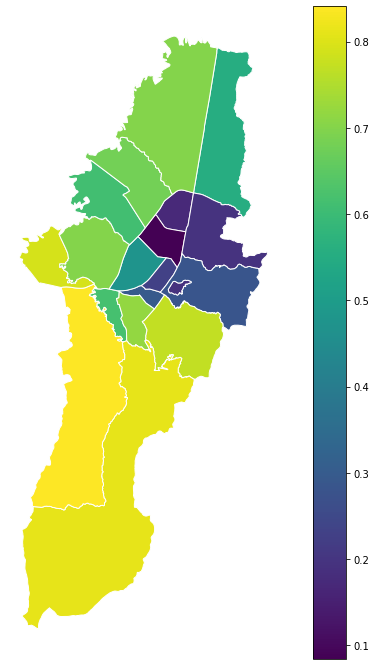

In [23]:
df_2014_2018 = df_prediction
name_experiment='_years_2014_2018'
map_predictability(df_2014_2018, str(Levels[0]), str(lenWindow), name_experiment)

## Localidades by year

In [87]:
years = list(df_input['ANIO'].unique())
years.remove(2019)

In [88]:
predValues_array = []
for year in years:
    df_by_period=df_by_date[df_by_date['ANIO']==year]

    min_date_on_period = df_by_period.reset_index().date.min()
    max_date_on_period = df_by_period.reset_index().date.max()

    expName = 'aggressiveBehavior_localidad_by_year_full_dataset'
    periodName = str(year)
    predValues = predictability_experiment_localidades(df_by_period,min_date_on_period,max_date_on_period,lenWindow,localidadesList,Levels,expName,periodName)
    predValues_array = predValues_array + list(predValues)
    
df_prediction = pd.DataFrame(predValues_array, columns=['experiment_name','period','localidad','lenWindow','crime_level','predictability','contingency','constancy'])


In [89]:
df_prediction["year"] = df_prediction.period
df_prediction['predictability']=pd.to_numeric(df_prediction['predictability'])

## Predictability map 2017

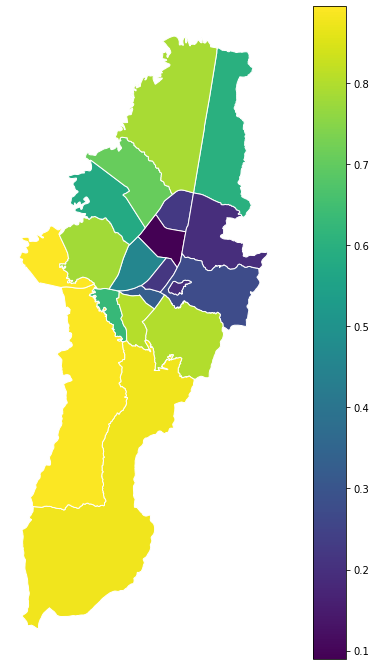

In [90]:
df_2017 = df_prediction[df_prediction['year']=='2017']
name_experiment='_by_year_2017'
map_predictability(df_2017, str(Levels[0]), str(lenWindow), name_experiment)

## Variance analysis

In [69]:
flagF = True
for localidad in localidadesList:
    df_by_localidad = df_prediction.loc[df_prediction['localidad'] == localidad]
    meanPredictability = df_by_localidad.loc[:,"predictability"].mean()
    variance = df_by_localidad.loc[:,"predictability"].var()
    for year in years:
        df_by_period = df_by_localidad.loc[df_by_localidad['year'] == str(year)]
        squareDifference = (df_by_period["predictability"].values[0] - meanPredictability)**2
        if flagF==True:
            flagF = False
            yearValues = np.array([localidad,year,meanPredictability,squareDifference]);
            generalValues = np.array([localidad,meanPredictability,variance]);
        else:
            yearValues = np.vstack((yearValues, [localidad,year,meanPredictability,squareDifference]))
            generalValues = np.vstack((generalValues, [localidad,meanPredictability,variance]))

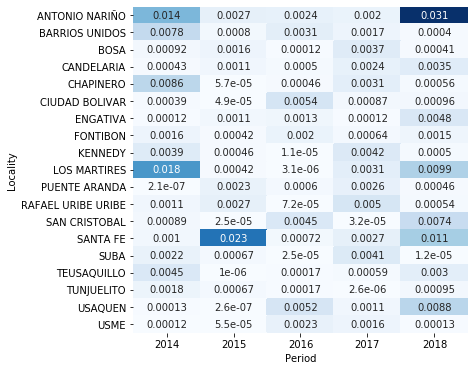

In [74]:
df_square_diff_prediction = pd.DataFrame(yearValues, columns=['localidad','period','mean_p','square_diff'])
periodCategories = list(df_variance_prediction['period'].unique())
expName = 'aggressiveBehavior_localidad_by_year_full_dataset'
table_predictability_variance(df_square_diff_prediction,lenWindow,localidadesList,periodCategories,expName,Levels[0])

In [75]:
df_variance_prediction = pd.DataFrame(generalValues, columns=['localidad','mean_predictability','variance_predictability'])
df_variance_prediction

,localidad,mean_predictability,variance_predictability
0,ANTONIO NARIÑO,0.3726679224752118,0.012966700768996966
1,ANTONIO NARIÑO,0.3726679224752118,0.012966700768996966
2,ANTONIO NARIÑO,0.3726679224752118,0.012966700768996966
3,ANTONIO NARIÑO,0.3726679224752118,0.012966700768996966
4,ANTONIO NARIÑO,0.3726679224752118,0.012966700768996966
...,...,...,...
90,USME,0.8358840074813981,0.0010741968085052934
91,USME,0.8358840074813981,0.0010741968085052934
92,USME,0.8358840074813981,0.0010741968085052934
93,USME,0.8358840074813981,0.0010741968085052934


### Localidades with higher predictability values

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "CIUDAD BOLIVAR"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "BOSA"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

### Localidades with low predictability values

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "TEUSAQUILLO"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "LOS MARTIRES"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

### Localidades with the lowest variance index

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "KENNEDY"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "SAN CRISTOBAL"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

### Localidades with the highest variance index

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "SANTA FE"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()

In [ ]:
df_localidad = df_prediction[df_prediction["localidad"] == "PUENTE ARANDA"]
fig = px.scatter(df_localidad, x="month", y="predictability",color="year",size="predictability")
#fig.update_xaxes(range=[-1, 12])
fig.update_yaxes(range=[0, 1.05])
fig.update_yaxes(nticks=20)
fig.show()